<a href="https://colab.research.google.com/github/DomWeisser/Unsupervised_Sea-Ice-Lead_Classification/blob/main/Unsupervised_Ice_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unsupervised Learning to Classify Sea Ice and Leads**

Using machine learning to analyze Earth observation satellite data offers a wide array of applications that contribute to sustainability efforts and deepens our understanding of the planet. In this tutorial, we will focus on classifying leads—fractures in sea ice—using both Sentinel-2 optical data and Sentinel-3 altimetry data. Leads play a crucial role in the polar climate system, and accurately identifying them is vital for marine navigation and ecosystem management.

Leads can be detected through both satellite imagery and altimetry. In optical satellite imagery, they are identified either visually or through automated image analysis that highlights differences in pixel values. On the other hand, satellite radar altimetry works by measuring surface height variations through radar pulses and analyzing the returning signals. Sea ice and leads can be differentiated by their distinct radar backscatter signatures and elevation profiles.

There will be two main tasks in this notebook:

This notebook will focus on two main tasks:

  1. Classifying sea ice and leads using Sentinel-2 optical data through image classification.
  2. Classifying sea ice and leads based on elevation data from Sentinel-3 radar altimetry.

# **Set-Up**

In [27]:
#Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Install required packages

!pip install rasterio
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.7 MB/s eta 0:00:00


In [3]:
#Import required packages

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from sklearn.mixture import GaussianMixture
import seaborn as sns
import rasterio
from netCDF4 import Dataset
from scipy.interpolate import griddata
import numpy.ma as ma
import glob
import scipy.spatial as spatial
from scipy.spatial import KDTree
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.signal import correlate
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
#Update with local path

file_path = '...'

# **Data Preprocessing**

In [4]:
#Import image bands

base_path = file_path + "Unsupervised Learning/S2A_MSIL1C_20190301T235611_N0207_R116_T01WCU_20190302T014622.SAFE/GRANULE/L1C_T01WCU_A019275_20190301T235610/IMG_DATA/" # You need to specify the path
bands_paths = {
    'B4': base_path + 'T01WCU_20190301T235611_B04.jp2',
    'B3': base_path + 'T01WCU_20190301T235611_B03.jp2',
    'B2': base_path + 'T01WCU_20190301T235611_B02.jp2'
}

# Read and stack the band images
band_data = []
for band in ['B4', 'B3', 'B2']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
band_stack = band_stack[3000:,:]    #Exclude Mountanious region in the North
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for K-means, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 3))

# **Image Classification**

In this tutorial, we will apply two types of unsupervised classification techniques to classify sea ice and leads in our satellite image sample. The first method is **K-means clustering**, which splits the dataset into k distinct group/clusters based on the similarity of the data's numerical features. The second method is the **Gaussian Mixture Model (GMM)**, a probabilistic model that represents data as a mixture of multiple Gaussian distributions. GMM assumes that the data is generated from a combination of several normal distributions, and it classifies data by identifying the mean and variance of each distribution.

**K-Means Implementation**

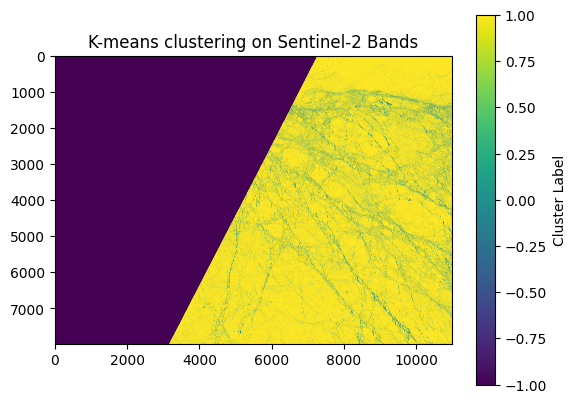

In [26]:
# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42).fit(X)
labels = kmeans.labels_

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place cluster labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('K-means clustering on Sentinel-2 Bands')
plt.colorbar(label='Cluster Label')
plt.show()

**GMM Implementation**

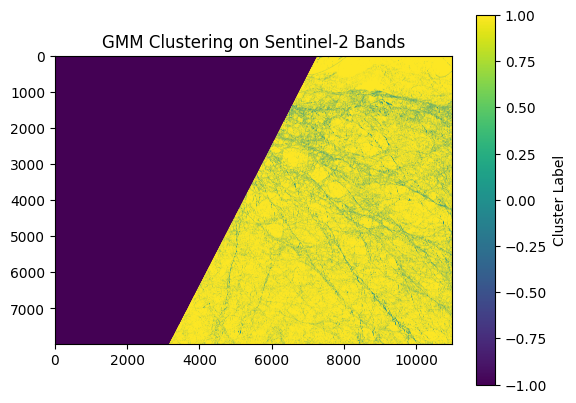

In [6]:
# GMM clustering
gmm = GaussianMixture(n_components=2, random_state=42).fit(X)
labels = gmm.predict(X)

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place GMM labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('GMM Clustering on Sentinel-2 Bands')
plt.colorbar(label='Cluster Label')
plt.show()

# **Altimetry Classification**

**Altimetry Data Preprocessing Functions**

Before delving into the modeling process, it's crucial to preprocess the data to ensure compatibility with our analytical models. This involves transforming the raw data into meaningful variables, such as peakiness and stack standard deviation (SSD), etc.

In [7]:
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    # from scipy import asarray as ar,exp
    from numpy import asarray as ar, exp

    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD

In [8]:
SAR_data = Dataset(file_path + '/Unsupervised Learning/S3A_SR_2_LAN_SI_20190307T005808_20190307T012503_20230527T225016_1614_042_131______LN3_R_NT_005.SEN3/enhanced_measurement.nc')

SAR_lat = unpack_gpod('lat_20_ku')
SAR_lon = unpack_gpod('lon_20_ku')
waves   = unpack_gpod('waveform_20_ku')
sig_0   = unpack_gpod('sig0_water_20_ku')
RIP     = unpack_gpod('rip_20_ku')
flag = unpack_gpod('surf_type_class_20_ku')

# Filter out bad data points using criteria (here, lat >= -99999)
find = np.where(SAR_lat >= -99999)
SAR_lat = SAR_lat[find]
SAR_lon = SAR_lon[find]
waves   = waves[find]
sig_0   = sig_0[find]
RIP     = RIP[find]

# Calculate additional features
PP = peakiness(waves)
SSD = calculate_SSD(RIP)

# Convert to numpy arrays (if not already)
sig_0_np = np.array(sig_0)
PP_np    = np.array(PP)
SSD_np   = np.array(SSD)

# Create data matrix
data = np.column_stack((sig_0_np, PP_np, SSD_np))

# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

Running peakiness function...


<ipython-input-7-054fe0e5e489>:39: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


Remove NaN values in the dataset.

In [9]:
# Remove any rows that contain NaN values
nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")

data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)]

mask = ~np.isnan(data_normalized).any(axis=1)
waves_cleaned = np.array(waves)[mask]
flag_cleaned = np.array(flag)[mask]

data_cleaned = data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
waves_cleaned = waves_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]
flag_cleaned = flag_cleaned[(flag_cleaned==1)|(flag_cleaned==2)]

Number of NaN values in the array: 1283


# **GMM Implementationon on Altimetry Data**

In [11]:
#Run GMM Model with 2 Gaussians

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data_cleaned)
clusters_gmm = gmm.predict(data_cleaned)

We can also inspect how many data points are there in each class of our clustering prediction.

In [12]:
# Get class sizes
unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Cluster counts:", class_counts)

Cluster counts: {0: 8879, 1: 3316}


We can plot the mean waveform of each class.

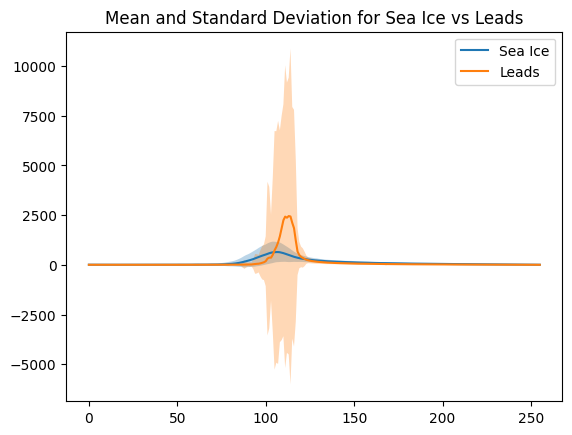

In [13]:
# Calculate mean and std for sea ice
mean_ice = np.mean(waves_cleaned[clusters_gmm==0],axis=0)
std_ice = np.std(waves_cleaned[clusters_gmm==0], axis=0)

# Plot mean and error bars for sea ice
plt.plot(mean_ice, label='Sea Ice')
plt.fill_between(range(len(mean_ice)), mean_ice - std_ice, mean_ice + std_ice, alpha=0.3)

# Calculate mean and std for leads
mean_lead = np.mean(waves_cleaned[clusters_gmm==1],axis=0)
std_lead = np.std(waves_cleaned[clusters_gmm==1], axis=0)

# Plot mean and error bars for leads
plt.plot(mean_lead, label='Leads')
plt.fill_between(range(len(mean_lead)), mean_lead - std_lead, mean_lead + std_lead, alpha=0.3)

# Construct plot title and axes
plt.title('Mean and Standard Deviation for Sea Ice vs Leads')
plt.legend()

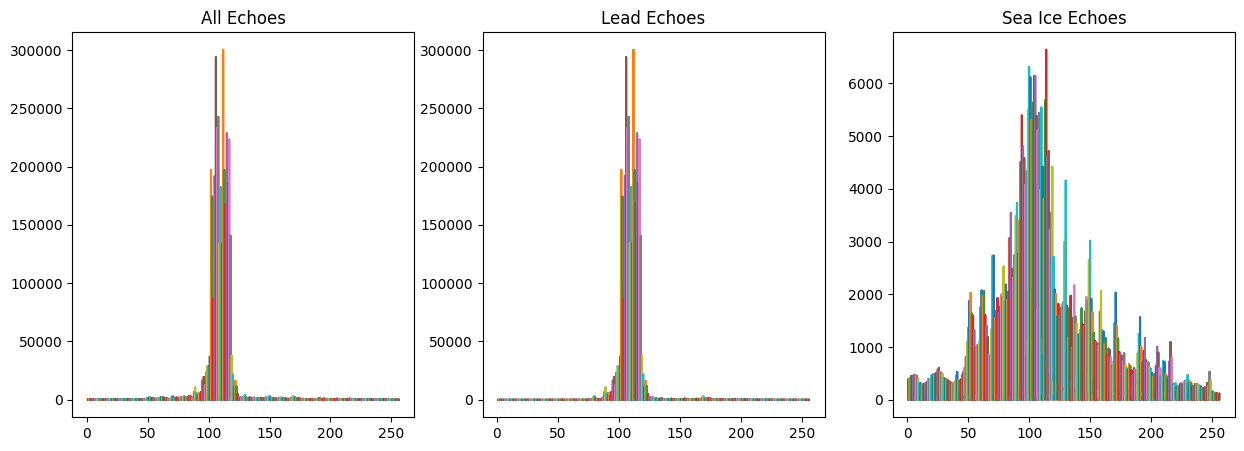

In [14]:
# Create three subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

x = np.stack([np.arange(1,waves_cleaned.shape[1]+1)]*waves_cleaned.shape[0])
ax[0].plot(x,waves_cleaned)  # plot of all the echos
ax[0].set_title('All Echoes')

x = np.stack([np.arange(1,waves_cleaned[clusters_gmm==1].shape[1]+1)]*waves_cleaned[clusters_gmm==1].shape[0])
ax[1].plot(x,waves_cleaned[clusters_gmm==1])  # plot echos for the lead cluster
ax[1].set_title('Lead Echoes')

x = np.stack([np.arange(1,waves_cleaned[clusters_gmm==0].shape[1]+1)]*waves_cleaned[clusters_gmm==0].shape[0])
ax[2].plot(x,waves_cleaned[clusters_gmm==0])  # plot echos for the sea ice cluster
ax[2].set_title('Sea Ice Echoes')

plt.show()

The plots above clearly show that the echoes are quite noisy due to positional shifts. These shifts occur because of variations in surface elevation. For each sample, the surface may be closer to or farther from the satellite, leading to a shift in the echo. However, the elevation itself does not affect the properties of the waveform. To accurately visualize the true waveform averages, we need to align the echoes before averaging.

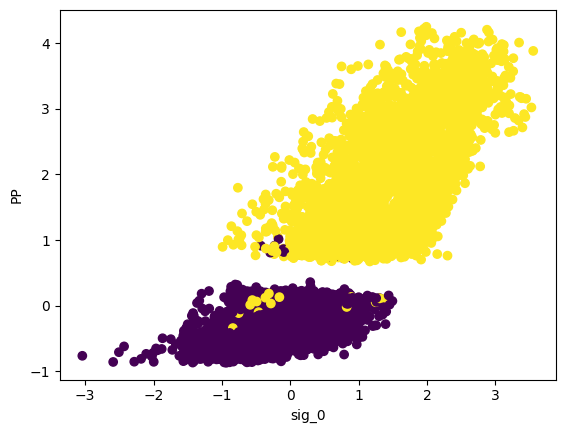

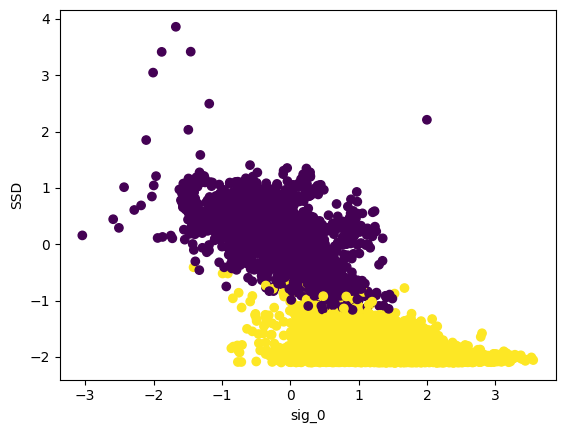

Text(0, 0.5, 'SSD')

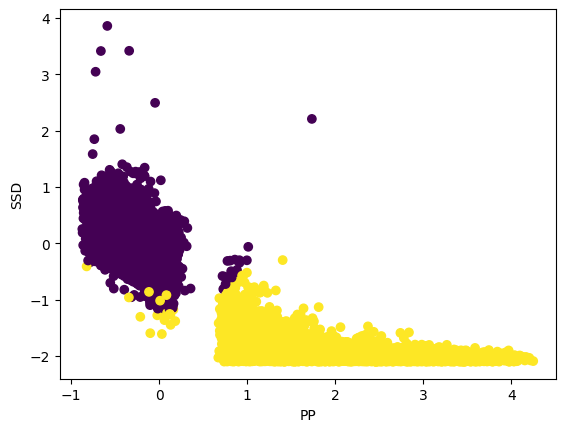

In [15]:
plt.scatter(data_cleaned[:,0],data_cleaned[:,1],c=clusters_gmm)
plt.xlabel("sig_0")
plt.ylabel("PP")
plt.show()
plt.scatter(data_cleaned[:,0],data_cleaned[:,2],c=clusters_gmm)
plt.xlabel("sig_0")
plt.ylabel("SSD")
plt.show()
plt.scatter(data_cleaned[:,1],data_cleaned[:,2],c=clusters_gmm)
plt.xlabel("PP")
plt.ylabel("SSD")

**Waveform Alignment Using Cross-Correlation**

This code aligns waveforms in the cluster where clusters_gmm == 0 by using cross-correlation.

Text(0.5, 1.0, 'Plot of 10 equally spaced functions where clusters_gmm = 0 (aligned)')

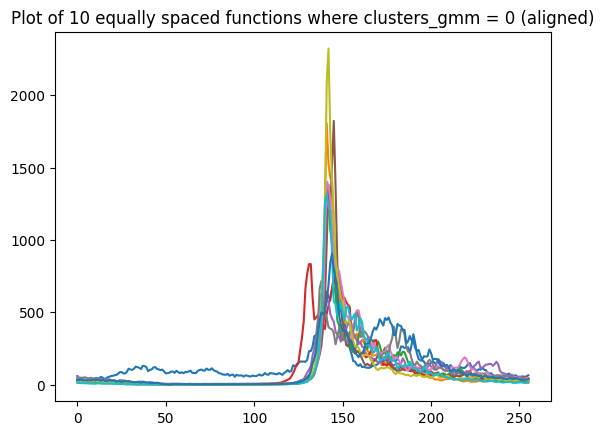

In [16]:
#Plot 10 ice echoes

# Find the reference point (e.g., the peak)
reference_point_index = np.argmax(np.mean(waves_cleaned[clusters_gmm==0], axis=0))

# Calculate cross-correlation with the reference point
aligned_waves = []
for wave in waves_cleaned[clusters_gmm==0][::len(waves_cleaned[clusters_gmm == 0]) // 10]:
    correlation = correlate(wave, waves_cleaned[clusters_gmm==0][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave = np.roll(wave, shift)
    aligned_waves.append(aligned_wave)

# Plot aligned waves
for aligned_wave in aligned_waves:
    plt.plot(aligned_wave)

plt.title('Plot of 10 equally spaced functions where clusters_gmm = 0 (aligned)')

In [17]:
# Align both classes into two separate datasets

# Find the reference point (e.g., the peak) sea ice
reference_point_index = np.argmax(np.mean(waves_cleaned[clusters_gmm==0], axis=0))

# Calculate cross-correlation with the reference point for all ice waves
aligned_ice_waves = []
for wave in waves_cleaned[clusters_gmm==0][::len(waves_cleaned[clusters_gmm == 0]) // ice_size]:
    correlation = correlate(wave, waves_cleaned[clusters_gmm==0][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave = np.roll(wave, shift)
    aligned_ice_waves.append(aligned_wave)

# Save as numpy array for modeling
aligned_ice_waves = np.array(aligned_ice_waves)
print("Aligned Ice Waves Shape: ",aligned_ice_waves.shape)

# Find the reference point (e.g., the peak) for leads
reference_point_index = np.argmax(np.mean(waves_cleaned[clusters_gmm==1], axis=0))

# Calculate cross-correlation with the reference point for all lead waves
aligned_lead_waves = []
for wave in waves_cleaned[clusters_gmm==1][::len(waves_cleaned[clusters_gmm == 1]) // lead_size]:
    correlation = correlate(wave, waves_cleaned[clusters_gmm==1][0])
    shift = len(wave) - np.argmax(correlation)
    aligned_wave = np.roll(wave, shift)
    aligned_lead_waves.append(aligned_wave)

# Save as numpy array for modeling
aligned_lead_waves = np.array(aligned_lead_waves)
print("Aligned Lead Waves Shape: ",aligned_lead_waves.shape)

Aligned Ice Waves Shape:  (8879, 256)
Aligned Lead Waves Shape:  (3316, 256)


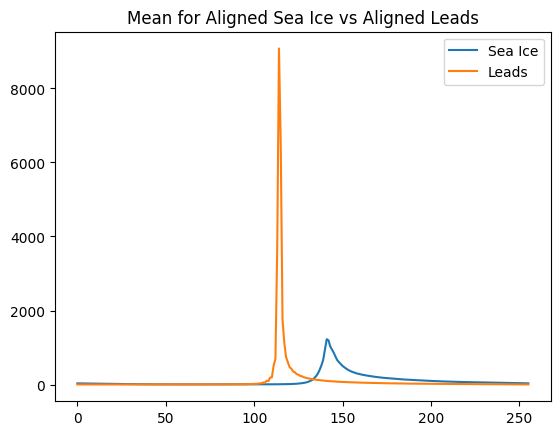

In [18]:
# Calculate mean and std for sea ice
aligned_mean_ice = np.mean(aligned_ice_waves,axis=0)
aligned_std_ice = np.std(aligned_ice_waves, axis=0)

# Plot mean  for sea ice
plt.plot(aligned_mean_ice, label='Sea Ice')

# Calculate mean and std for leads
aligned_mean_ice = np.mean(aligned_lead_waves,axis=0)
aligned_std_ice = np.std(aligned_lead_waves, axis=0)

# Plot mean and error bars for sea ice
plt.plot(aligned_mean_ice, label='Leads')

# Construct plot title and axes
plt.title('Mean for Aligned Sea Ice vs Aligned Leads')
plt.legend()

We can see from the plot above that there is much less noise in the aligned waves.

# **K Means Implementation on Altimetry Data**

We now repeat the modeling process with K-Means.

In [19]:
# Run KMeans with 2 clusters

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_cleaned)
clusters_km = kmeans.labels_

In [20]:
unique, counts = np.unique(clusters_km, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Cluster counts:", class_counts)

Cluster counts: {0: 8946, 1: 3249}


**Compare both Models with ESA Data**

We will create confusion matrices for both the GMM and K-Means models to compare their performance against the ESA dataset.

In the ESA dataset, sea ice is labeled as 1 and leads as 2. To ensure our predicted labels align, we will subtract 1 from the ESA dataset labels before making the comparison.

In [21]:
flag_cleaned_modified = flag_cleaned - 1
true_labels = flag_cleaned_modified   # true labels from the ESA dataset

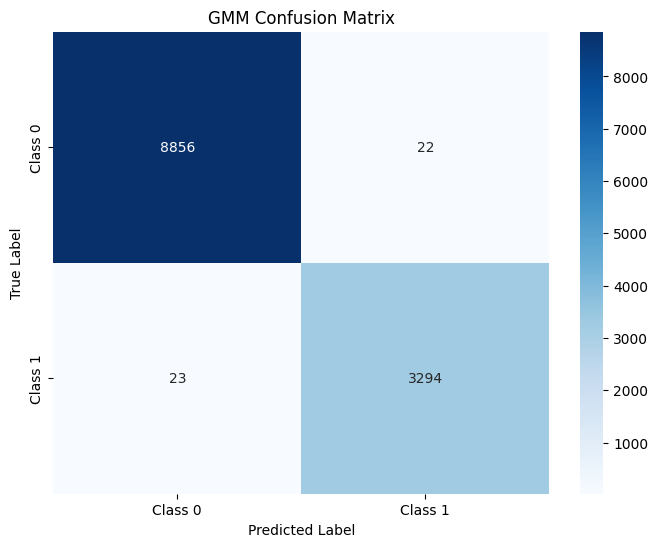


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8878
         1.0       0.99      0.99      0.99      3317

    accuracy                           1.00     12195
   macro avg       1.00      1.00      1.00     12195
weighted avg       1.00      1.00      1.00     12195



In [22]:
# Create Confusion Matrix for GMM

predicted_gmm = clusters_gmm

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_gmm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("GMM Confusion Matrix")
plt.show()

# Compute classification report
class_report = classification_report(true_labels, predicted_gmm)

# Print classification report
print("\nClassification Report:")
print(class_report)

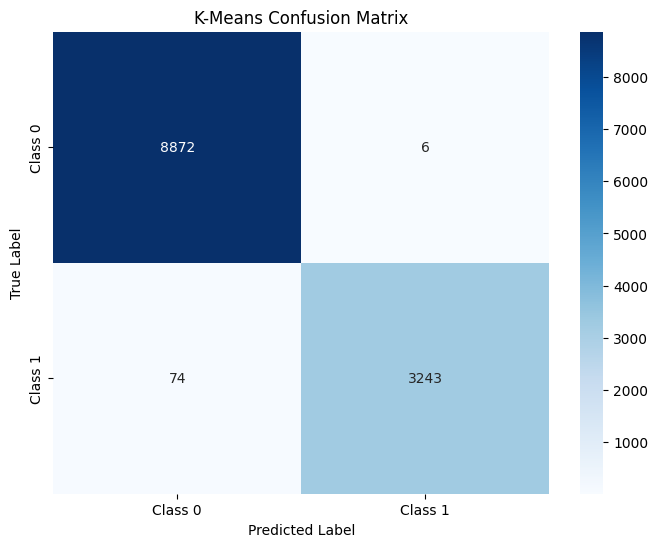


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      8878
         1.0       1.00      0.98      0.99      3317

    accuracy                           0.99     12195
   macro avg       0.99      0.99      0.99     12195
weighted avg       0.99      0.99      0.99     12195



In [23]:
# Create Confusion Matrix for K-Means

predicted_km = clusters_km

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_km)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("K-Means Confusion Matrix")
plt.show()


# Compute classification report
class_report = classification_report(true_labels, predicted_km)

# Print classification report
print("\nClassification Report:")
print(class_report)

# **Conclusion**

Based on the confusion matrices and classification reports, we observe that the GMM and K-Means models perform similarly. However, the GMM model has fewer overall incorrect classifications and shows less class imbalance among the incorrect classifications. Therefore, the GMM is the preferred model for this task.